In [7]:
from sklearn.datasets import fetch_openml
gina_prior = fetch_openml('gina_prior', version=1)
gina_prior.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
gina_prior["DESCR"]

'**Author**:   \n**Source**: Unknown - Date unknown  \n**Please cite**:   \n\n**Note: derived from MNIST?**\n\nDatasets from the Agnostic Learning vs. Prior Knowledge Challenge (http://www.agnostic.inf.ethz.ch)\n\nDataset from: http://www.agnostic.inf.ethz.ch/datasets.php\n\nModified by TunedIT (converted to ARFF format)\n\n\nGINA is digit recognition database\n\nThe task of GINA is handwritten digit recognition. For the "prior knowledge track" we chose the problem of separating one-digit odd numbers from one-digit even numbers. The original pixel map representation is provided. This is a two class classification problem with sparse continuous input variables, in which each class is composed of several clusters. It is a problem with heterogeneous classes.\n\nData type: non-sparse\nNumber of features: 784\nNumber of examples and check-sum:\nPos_ex Neg_ex Tot_ex Check_sum\nTrain  1550  1603  3153 82735983.00\nValid   155   160   315 8243382.00\n\nThis dataset contains samples from both t

In [9]:
X, y = gina_prior["data"], gina_prior["target"]

In [10]:
X = X.to_numpy()
y = y.to_numpy()

In [11]:
X.shape, y.shape

((3468, 784), (3468,))

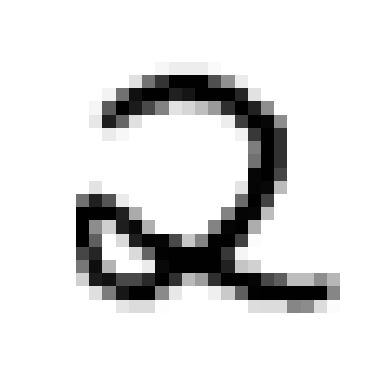

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [13]:
y[0]

'1'

In [14]:
import numpy as np
y = y.astype(np.uint8)

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [16]:
y_train_5 = (y_train == 1)  # True for all 1s, False for all other digits
y_test_5 = (y_test == 1)

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8512110726643599
0.7923875432525952
0.8131487889273357


In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.81574394, 0.82612457, 0.81228374])

In [21]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.51903114, 0.50951557, 0.49653979])

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[1520,  243],
       [ 388, 1317]])

In [25]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[1763,    0],
       [   0, 1705]])

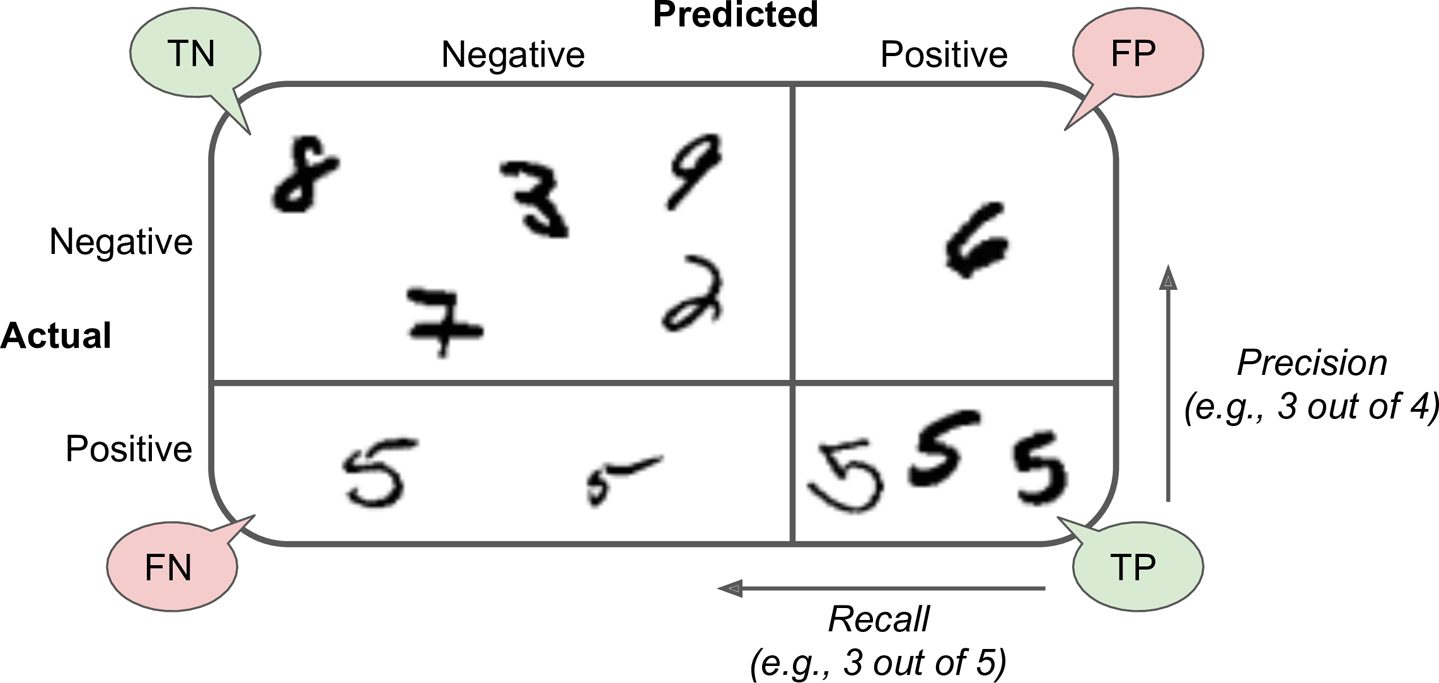

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.7724340175953079

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8067381316998468

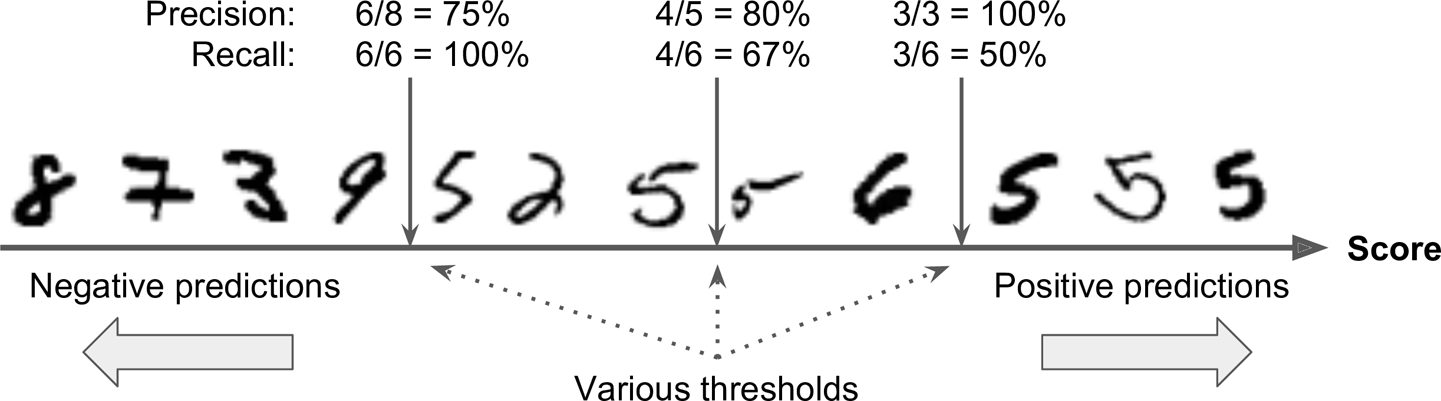

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([501970.40972069])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores.shape

(3468,)

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

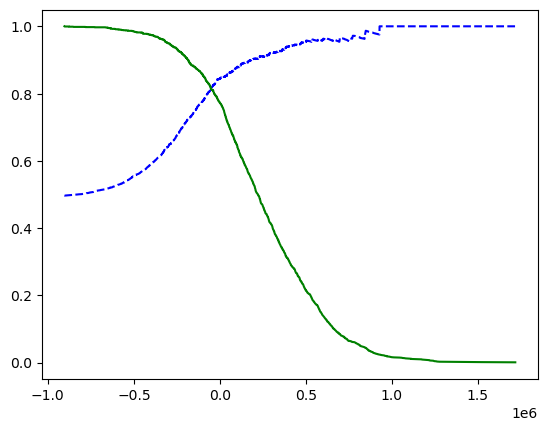

In [34]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [35]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9003868471953579

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.546041055718475

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

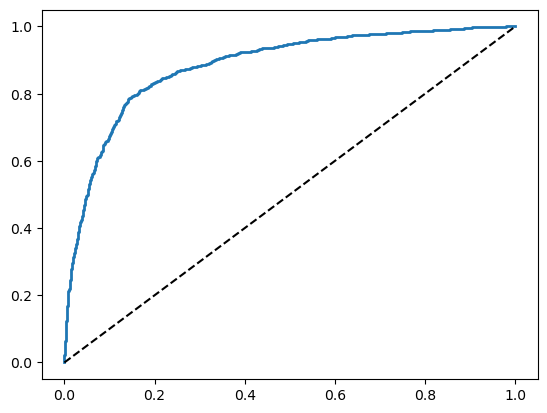

In [41]:
plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
# receiver operating characteristics area under curve

In [43]:
roc_auc_score(y_train_5, y_scores)

0.8841131568923274

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [45]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

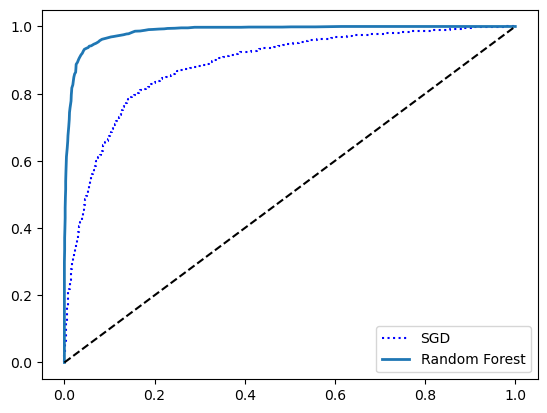

In [46]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9855584738756752

In [48]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([1], dtype=uint8)

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([-1.94914639])

In [50]:
np.argmax(some_digit_scores)

0

In [51]:
svm_clf.classes_

array([  1, 255], dtype=uint8)

In [52]:
svm_clf.classes_[1]

255

In [53]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([1], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

1

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([1], dtype=uint8)

In [56]:
sgd_clf.decision_function([some_digit])

array([-501970.40972069])

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.81574394, 0.82612457, 0.81228374])

$x'=\frac{x-\mu}{\sigma}$

In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8200692 , 0.81141869, 0.82871972])

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[1358,  347],
       [ 277, 1486]])

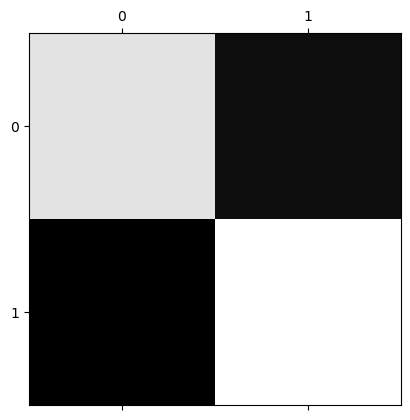

In [60]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

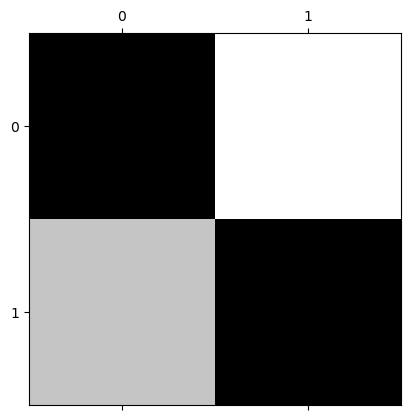

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [63]:
# def plot_digits(x, y):
#     plt.imshow(x, y)

TypeError: 'int' object is not subscriptable

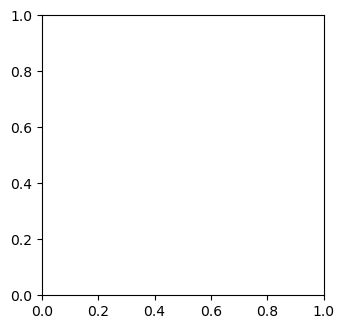

In [66]:
cl_a, cl_b = 3, 5
# X_train = [12, 1, 2, 54, 1, 32, 14]
# y_train, y_train_pred = 5, 3
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

/usr/local/bin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/usr/local/bin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/usr/local/bin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

0.9749654218533887

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined